In [22]:
import pint; from pint import UnitRegistry; AQ = UnitRegistry(system='atomic').Quantity
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

### The reference system (from the Continuum paper)

<IPython.core.display.Javascript object>


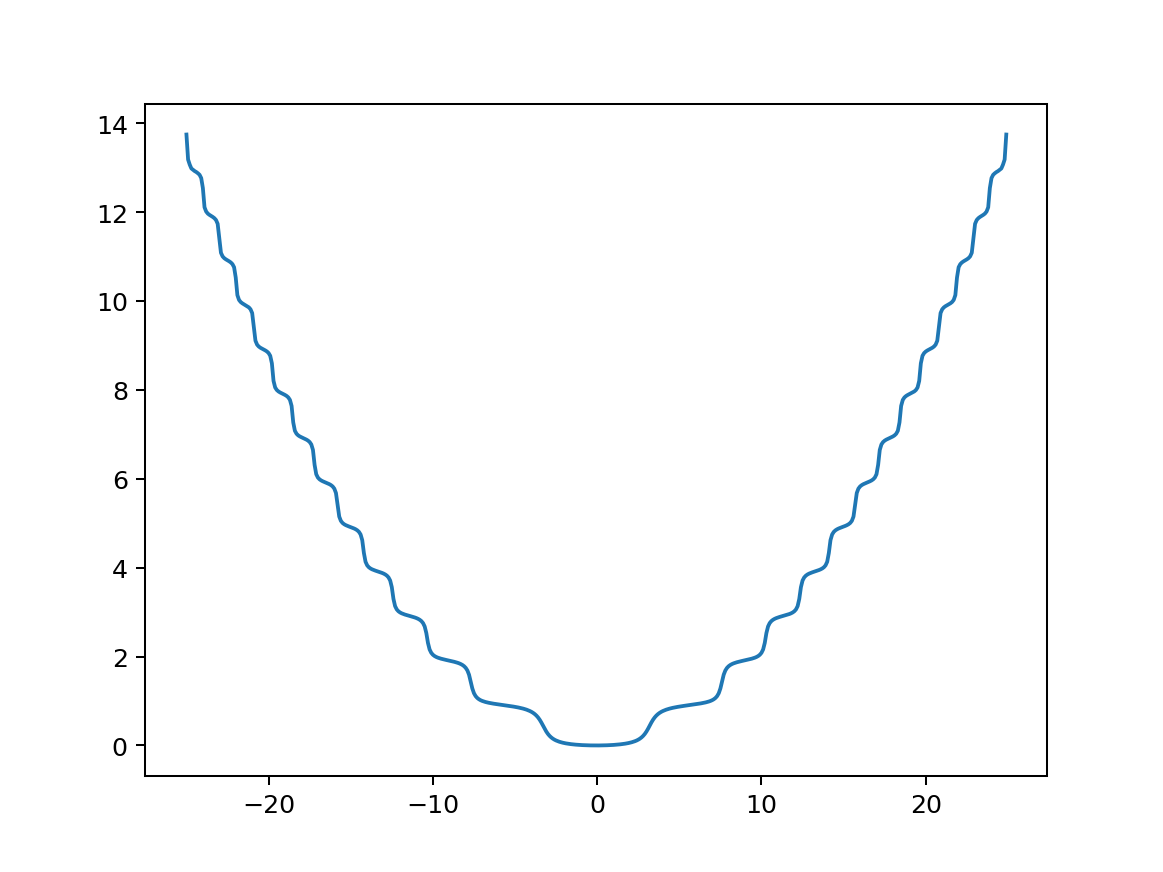

In [23]:
numerical_results = np.loadtxt('standard_system.txt')
x_nr = numerical_results[:,0]/10
x_nr = AQ(x_nr,'micrometers')
Ntot_nr = numerical_results[:,1]
Ntot_nr -= np.min(Ntot_nr)
plt.figure()
plt.plot(x_nr,Ntot_nr)

### Geometry of the facet

In [24]:
npts = 500
midpt = np.round(npts/2).astype(int)
L = AQ(25,'micrometer')
x = np.linspace(-L,L,npts)

### Ice parameters

In [25]:
sigma_0 = 0.19
c_r = 0.0025
D = AQ(2e-4,'micrometer^2/microsecond')
nukin = AQ(0.16,'1/second')
sigma_I_corner = .20
beta = 0.65
Nbar = 1
Nstar = 0.14

### Functions for $x$ and $N_{SS}$
As defined by Eq. 20 of the paper (apart from the factor of 1000),

$$
x = {v_{kin}L^2c_r^\beta \sigma_{I,corner}\over D} \times 1000
$$

and

$$
N_{SS} = Mx  + B
$$

The slope and intercept parameters are, for sinusoidal inhomogeneity, $M = 2.7$ and $B = 2.9$, while for parabolic inhomogeneity, $M = 2.5$ and $B = 1.6$.

In [26]:
def get_xparameter(nukin,L,c_r,beta,sigma_I_corner,D):
    """
    Parameters c_r and sigma_I_corner are fractions (not %)
    The x-parameter returned equals what's plotted in Fig 11 (no factor of 1000)
    """
    xparameter = nukin*L**2*c_r**beta*sigma_I_corner/D*1e3
    xparameter.ito('dimensionless')
    return xparameter

def get_NSS(xparameter,inhomogeneity_type='parabolic'):
    if inhomogeneity_type=='sinusoidal':
        print('Using sinusoidal vapor inhomogeneity')
        M = 2.7
        B = 2.9
    else:
        print('Using parabolic vapor inhomogeneity')
        M = 2.500
        B = 1.6    
    NSS = M*xparameter+B
    return NSS

### Replicating Figure 11

Using parabolic vapor inhomogeneity
Standard state:
   x = 2.0354526576845213 dimensionless
   NSS = 6.688631644211304 dimensionless
Using parabolic vapor inhomogeneity


<IPython.core.display.Javascript object>


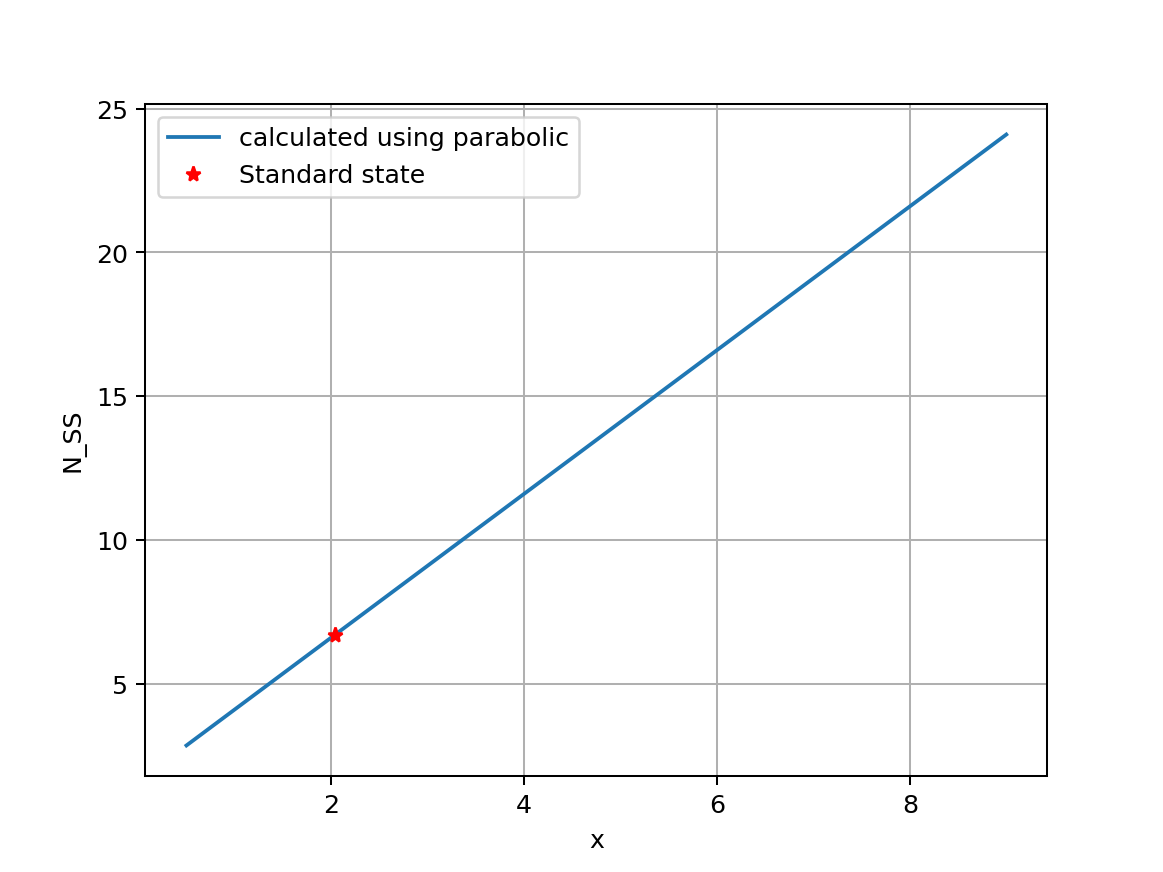

In [27]:
# inhomogeneity_type = 'sinusoidal'
inhomogeneity_type = 'parabolic'
xparameter_ref = get_xparameter(nukin,L,c_r,beta,sigma_I_corner,D)
NSS_ref = get_NSS(xparameter_ref,inhomogeneity_type)
print('Standard state:')
print('   x =',xparameter_ref)
print('   NSS =',NSS_ref)

xparameter_range = np.linspace(0.5,9)
NSS_range = get_NSS(xparameter_range,inhomogeneity_type)

plt.figure()
plt.plot(xparameter_range,NSS_range,label='calculated using '+inhomogeneity_type)
plt.plot(xparameter_ref,NSS_ref,'r*',label='Standard state')
plt.grid(True)
plt.xlabel('x')
plt.ylabel('N_SS')
plt.legend()

### Computing the shape of the inhomogeneous water vapor field
Equation 13 of the paper says
$$
\sigma_I(x) = \sigma_{I,corner} \times f_{inhomog}(x)
$$

where we have our choice between the sinusoidal form, Eq. 14,
$$
f_{inhomog}(x) = f_{sinusoidal}(x) = 1 - c_r\bigl [1 + cos\bigl ({x \over L}\pi \bigr) \bigr ] /2
$$

or the parabolic form,

$$
f_{inhomog}(x) = f_{parabolic}(x) = c_r\bigl({x \over L} \bigr )^2 + (1-c_r)
$$

It's also going to be convenient to define

$$
\delta \sigma_l(x) = \sigma_{l,corner}  \times \delta f_{inhomog}(x)
$$

where

$$
\delta f_{inhomog}(x) = f_{inhomog} - 1
$$

<IPython.core.display.Javascript object>


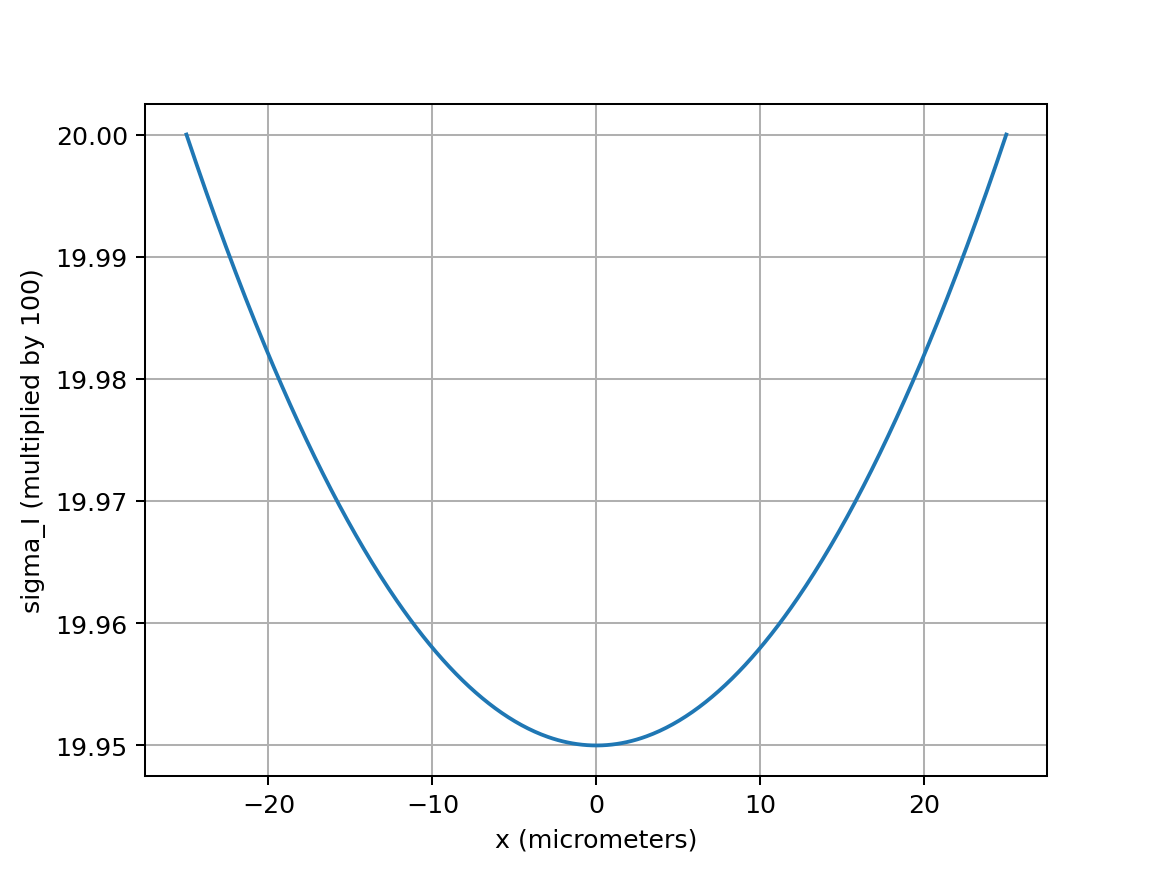

<IPython.core.display.Javascript object>


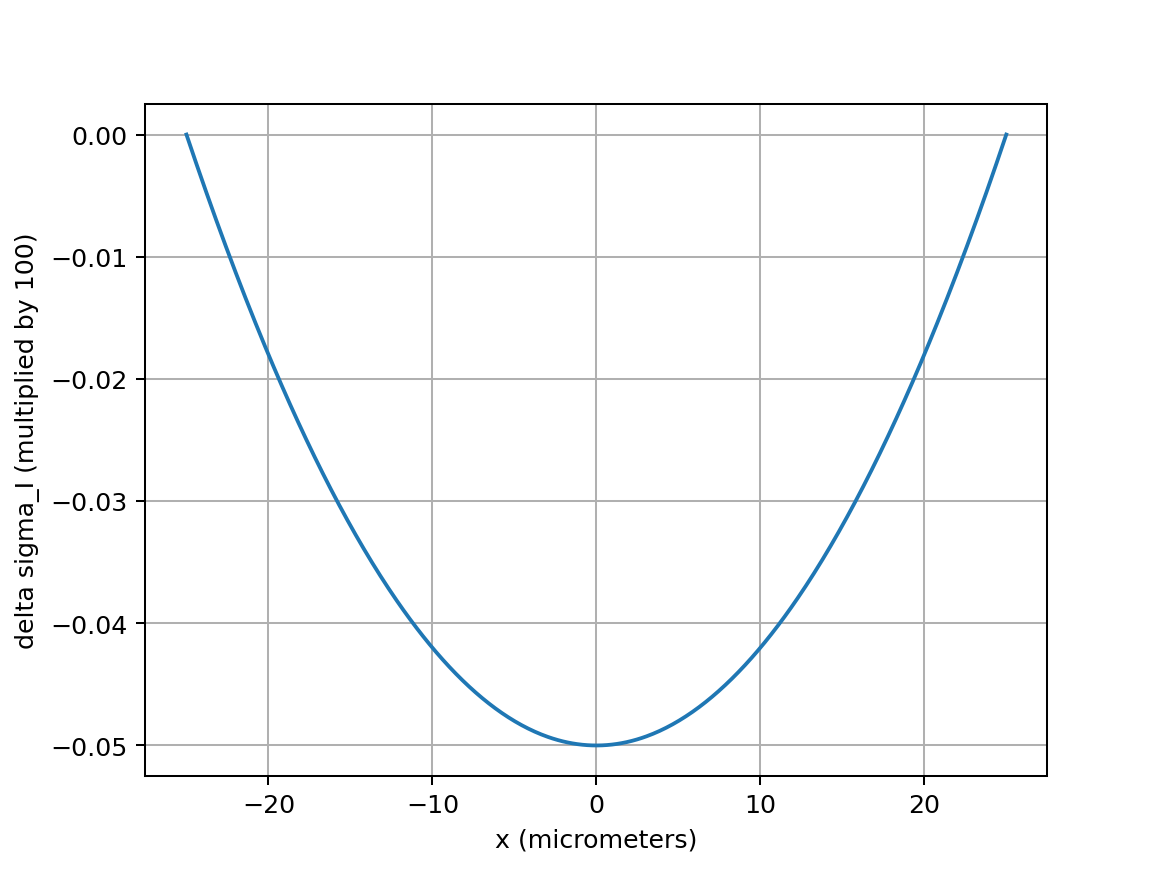

In [28]:
if inhomogeneity_type == 'sinusoidal':
    f_inhomog = 1 - c_r * (1+np.cos(x/L*np.pi))/2
else:
    f_inhomog = c_r * (x/L)**2 + (1-c_r)
fp_inhomog = f_inhomog - 1

delta_sigma_I = sigma_I_corner*fp_inhomog
sigma_I = sigma_I_corner*f_inhomog

plt.figure()
plt.plot(x,sigma_I*100)
plt.xlabel('x (micrometers)')
plt.ylabel('sigma_I (multiplied by 100)')
plt.grid(True)

plt.figure()
plt.plot(x,delta_sigma_I*100)
plt.xlabel('x (micrometers)')
plt.ylabel('delta sigma_I (multiplied by 100)')
plt.grid(True)

### Constructing the shape of the steady-state profile
We'll start with the idea that we can reconstruct an approximate surface, $N_{ice}(x)$, using its slope,

$$
N_{ice}(x) = \int_{-L}^{x}{\partial N_{ice}\over \partial x}dx \ \ \ \ (1)
$$

Now let's claim that the step width is related to the imposed supersaturation according to

$$
{\partial N_{ice}\over \partial x} \propto {\delta(\sigma_I)^n } \ \ \ \ (2)
$$

where (once we've integrated, according to Eq. 1), we'll normalize so that $N_{ice}$ goes from zero to the observed (numerically simulated) $N_{SS}$.

<IPython.core.display.Javascript object>


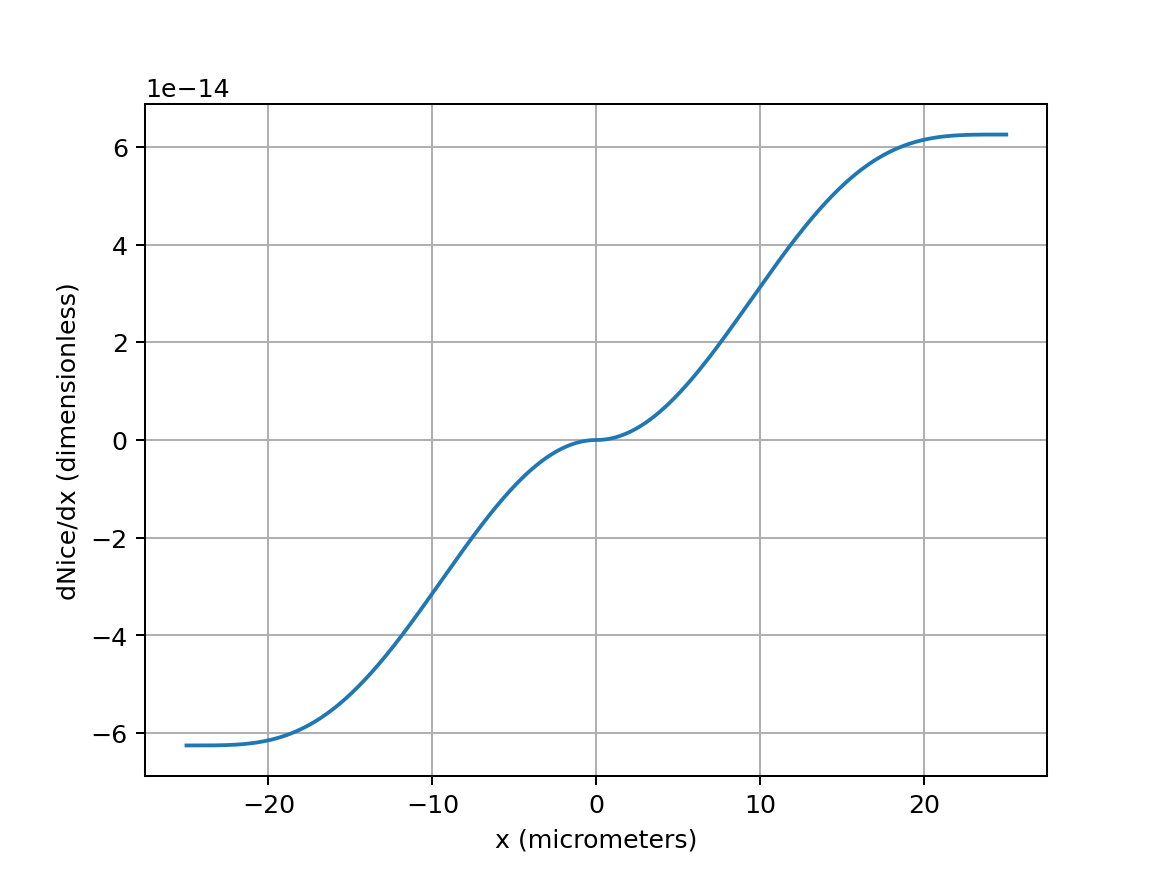

Range of Nicen before scaling =  9.306854771539276e-13 micrometer
cprimen =  6.997635166570884e-14 micrometer
Units of Nicen = dimensionless


<IPython.core.display.Javascript object>


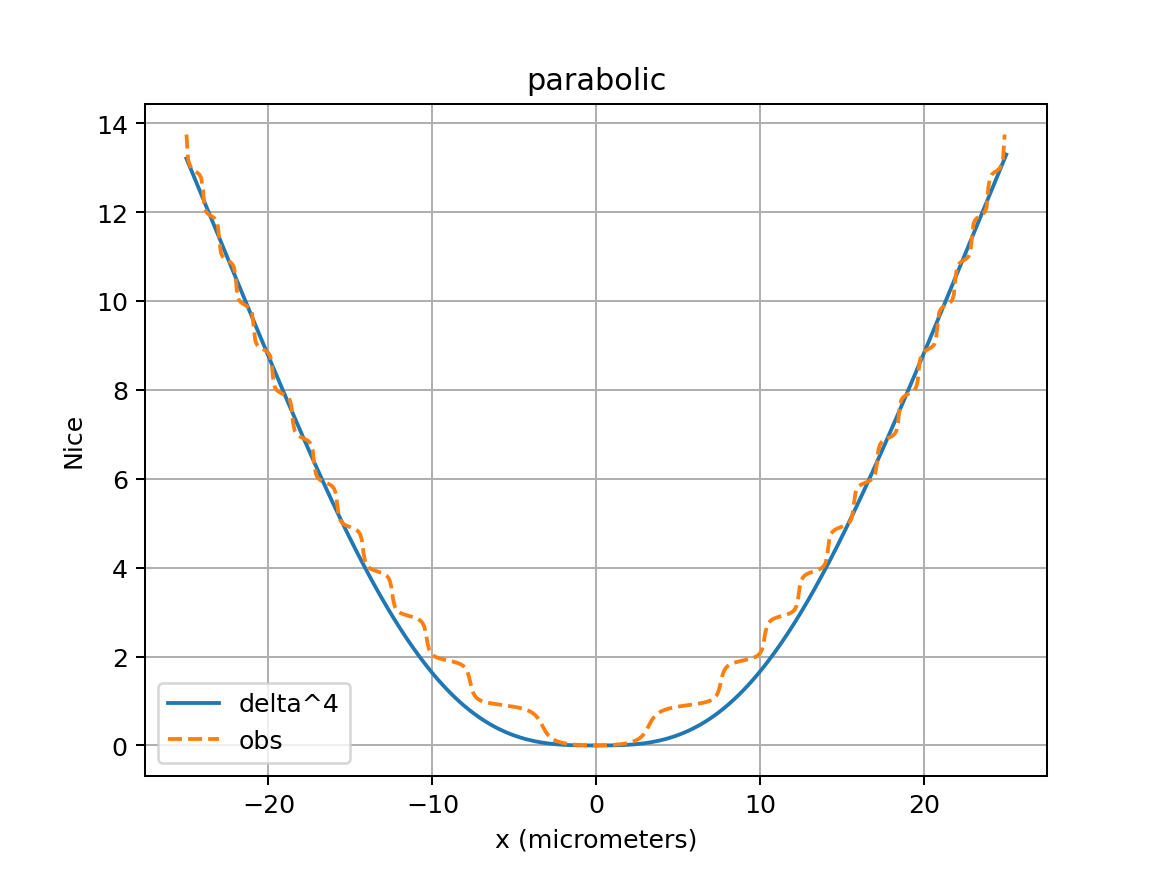

Text(0.5, 1.0, 'parabolic')

In [29]:
NSS_ref = 13.3
npow = 4
Nicenp = np.abs(delta_sigma_I**npow)
Nicenpmax = np.max(Nicenp)
Nicenp -= Nicenpmax
for i in range(len(Nicenp)):
    if x[i].magnitude > 0:
        Nicenp[i] = -Nicenp[i]
plt.figure()
plt.plot(x,Nicenp)
plt.xlabel('x (micrometers)')
plt.ylabel('dNice/dx ('+str(Nicenp.units)+')')
plt.grid(True)
 
dx = x[1]-x[0]
Nicen = np.cumsum(Nicenp)*dx
Nicen -= np.min(Nicen)
print('Range of Nicen before scaling = ', np.max(Nicen) )
cprimen = np.max(Nicen)/NSS_ref
print('cprimen = ', cprimen)
Nicen /= cprimen
print('Units of Nicen =', Nicen.units)

plt.figure()
plt.plot(x,Nicen,label='delta^'+str(npow))
plt.xlabel('x (micrometers)')
plt.ylabel('Nice')
plt.grid(True)
plt.plot(x_nr,Ntot_nr,'--',label='obs')
plt.legend()
plt.title(inhomogeneity_type)

### Former (obsolete) notes
We'll start with the idea that we can reconstruct an approximate surface, $N_{ice}(x)$, using its slope,

$$
N_{ice}(x) = \int_{-L}^{x}{\partial N_{ice}\over \partial x}dx \ \ \ \ (1)
$$

The integrand is a function of the step width, $w$,

$$
{\partial N_{ice}\over \partial x} = \mp {1 \over w} \ \ \ \ (2)
$$

in which the sign choice is determined by whether $x$ lies to the left or right of facet center. According to Eq. 25 of the paper, we have

$$
w^2 = {k F(\sigma_I) \over \delta(\sigma_m) \ \nu_{kin}} \ \ \ \ (3)
$$

where $k$ is defined in Eq. 26,

$$
k = {D \ \sigma_o \ \nu_{kin} \over 2 N^*} \ \ \ \ (4)
$$

and $F(\sigma_I)$ is defined in Eq. 27 (and displayed in Fig. 12). These combine to form

$$
{\partial N_{ice}\over \partial x}
= \sqrt{ {\delta(\sigma_m) \nu_{kin}} \over k F(\sigma_I) }
= \sqrt{ {\delta(\sigma_m) } 2 N^* \over D \sigma_o F(\sigma_I) } \ \ \ \ (5)
$$

Once ${\partial N_{ice}\over \partial x}$ is determined, we can use Eq. 1 to find $N_{ice}(x)$.

### Predicting stability to perturbations (doesn't work as expected)

In [30]:
# f_ss = Nice
# l = L

# eps = 1
# n = 0
# f_perturbation = eps*np.cos((n+.5)*np.pi*x/l)
# f_perturbed = f_ss + f_perturbation
# plt.figure()
# plt.plot(x,f_ss,'k',label='steady-state facet')
# plt.plot(x,f_perturbed,'b',label='perturbed steady state')
# plt.grid(True)
# plt.xlabel('x (um)')
# plt.ylabel('Nice')
# plt.legend()
# f_perturbed_original = f_perturbed

In [31]:
# slope_ss_squared = np.gradient(f_ss,dx,edge_order=2)**2
# growth_factor2 = AQ(2,'micrometer^2')
# growth_factor = np.sqrt(growth_factor2)
# f_perturbed = f_perturbed_original

# for i in range(4):
#     print(i)
#     slope_perturbed_squared =  np.gradient(f_perturbed,dx,edge_order=2)**2

#     plt.figure()
#     plt.plot(x,slope_ss_squared,'k',label='steady state')
#     plt.plot(x,slope_perturbed_squared,'b',label='perturbed')
#     plt.grid(True)
#     plt.legend()
#     plt.title('squared slopes')

#     f2_deviation = slope_perturbed_squared - slope_ss_squared
#     plt.figure()
#     plt.plot(x,f2_deviation,'--',label='perturbed - ss')
#     plt.grid(True)
#     plt.legend()
#     plt.title('f2_deviation')

#     correction = growth_factor2*f2_deviation

#     f_perturbed_later = f_perturbed + correction
#     shift = np.mean(f_ss-f_perturbed_later)
#     f_perturbed_later += shift
#     plt.figure()
#     plt.plot(x,f_ss,'k',label='steady state')
#     plt.plot(x,f_perturbed,'b',label='perturbed with low-frequency noise')
#     plt.plot(x,f_perturbed_later,'b--',label='recovery based on diffusive slowdown heuristic')
#     plt.grid(True)
#     plt.xlabel('x (um)')
#     plt.ylabel('Ice layers')
#     plt.legend()

#     plt.figure()
#     real_correction = f_perturbed_later - f_perturbed
#     plt.plot(x,f_perturbation*real_correction,'b',label='correlation')
#     plt.grid(True)
#     plt.title('Correlation < 0 => autocorrects')
#     plt.legend()

#     f_perturbed = f_perturbed_later    